## Twitter Sentiment Analysis


* Data Source: https://www.kaggle.com/kazanova/sentiment140

This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment.

Content

* It contains the following 6 fields:

* target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* ids: The id of the tweet ( 2087)
* date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* flag: The query (lyx). If there is no query, then this value is NO_QUERY.
* user: the user that tweeted (robotickilldozr)
* text: the text of the tweet (Lyx is cool)


#### Imports

* The main python packages that are used are: 
    * `NLTK` and regular expresions for input text manipulations
    * Classifiers and metrics for evaluation from `Sklearn`
    * `Pandas` and `Matplotlib` to depict results
    * `Keras` as a neural-network library

In [1]:
import numpy as np
import pandas as pd
from collections import Counter

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

import re
from nltk.stem import WordNetLemmatizer
stemmer = WordNetLemmatizer()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split  

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/giorgosfat17/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/giorgosfat17/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Load data
file = "training.1600000.processed.noemoticon.csv"
cols = ['target','id','date','flag','user','text']
df = pd.read_csv(file,encoding =  "ISO-8859-1",header=None, names=cols)

# 0 for positive / 1 for negative
df['target'] = (df['target']==4).astype(int)

y = np.array(df.target)
X  = list(df.text)

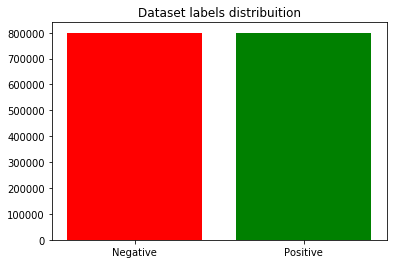

In [3]:
# Count the number of entities in each category
target_cnt = Counter(df.target)
plt.figure(figsize=(6,4))
plt.bar(target_cnt.keys(), target_cnt.values(),tick_label =('Negative', 'Positive'),color=['r','g'])
plt.title("Dataset labels distribuition")
plt.show()

* From the above plot it can be seen that the dataset is balanced. We have 800,000 positive and and negative tweets.

Each tweet has the following format:

In [4]:
df.text[45]

"@Viennah Yay! I'm happy for you with your job! But that also means less time for me and you... "

#### Preprocessing

* We will remove from each tweet special characters, single characters, multiple spaces and prefixed letters and prefix such as '@nickname'.
* Everything will be converted to Lowercase.
* Using the WordNet Lemmatizer we will keep the stem of each word (only for words in the WordNet).

In [5]:
tweets = []
for i in range(len(X)):
    
    tweet = re.sub(r"@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', str(X[i]))
    
    # remove all single characters
    tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', tweet)

    # Substituting multiple spaces with single space
    tweet = re.sub(r'\s+', ' ', tweet, flags=re.I)
    
    # Converting to Lowercase
    tweet = tweet.lower()

    # Lemmatization
    tweet = tweet.split()

    tweet = [stemmer.lemmatize(word) for word in tweet]
    tweet = ' '.join(tweet)
    tweets.append(tweet)

After preprocessing the above tweet is transformed into:

In [6]:
tweets[45]

'yay m happy for you with your job but that also mean le time for me and you'

#### Split dataset into train (70%) & development(10%) & test (30%)

* Due to the large number of available data (1,600,000) we will do our analysis in a random 10% sample, in order to speed up computations. (Use of all the data did not impove the accuracy of the classifier)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(tweets, y, test_size=0.3, random_state=23828748)
# keep only the 20%
X_train,X_dev, X_test, y_train,y_dev, y_test = X_train[:160000],X_test[:32000], X_test[32000:96000], y_train[:160000], y_test[:32000],y_test[32000:96000]

#### Feature extraction (Tf*IDF n-gram features)

* In order to perform the classification (positive/negative) among the tweets, we represent them as `bags of words/ngrams`.
* We build features using the TF*IDF score of single words and bigrams.

    * TF: how frequent each vocabulary word is in the given tweet. 
    * IDF: how rare each word of an tweet is in the language.
    
* Each tweet is transformed in a TF*IDF vector with length same as the number of the features. Thus, most values of this vector will be 0, as only a few of all the features will be present in a given tweet.

* After removing the stop-words, we extract as features the 10000 words/bigrams with the highest frequency across the corpus.

In [8]:
#Use unigram & bi-gram tf*idf features
vectorizer = TfidfVectorizer(max_features=10000,stop_words=stopwords.words('english'))

x_train = vectorizer.fit_transform(X_train)
x_dev  = vectorizer.transform(X_dev)
x_test = vectorizer.transform(X_test)

#### Define evaluation metrics

In [11]:
def recall(y_true, y_pred):
    
    """
    Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision(y_true, y_pred):
    
    """
    Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    Source
    ------
    https://github.com/fchollet/keras/issues/5400#issuecomment-314747992
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1(y_true, y_pred):
    
    """Calculate the F1 score."""
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r))


def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)), axis=1)

### MLP classifier in Keras using tf*idf features

In [ ]:
!pip install keras-tqdm

In [11]:
# to run tensorflow on mac
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [12]:
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras_tqdm import TQDMNotebookCallback
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam
from keras import backend as K

model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1] , activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64,  activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,  activation='sigmoid'))

print(model.summary())
model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=[precision, recall, f1, accuracy])

checkpoint = ModelCheckpoint('keras_tf_idf_model', monitor='val_f1', verbose=1, save_best_only=True, mode='max')

earlystopping=EarlyStopping(monitor='val_f1', patience=2, verbose=1)

history = model.fit(x_train, y_train,
              batch_size=32,
              epochs=3,
              verbose = 0,
              callbacks=[checkpoint,earlystopping,TQDMNotebookCallback()],
              validation_data=(x_dev, y_dev),
              shuffle=True)

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                640064    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 644,289
Trainable params: 644,289
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76752, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76752



Epoch 00003: val_f1 improved from 0.76752 to 0.76854, saving model to keras_tf_idf_model



## Visualize Model Training History

In [18]:
clf = SGDClassifier(loss="log", penalty="l2", tol=0.0001)
clf.fit(x_train, y_train)
predictions = clf.predict(x_train)
score = f1_score(y_train,predictions)
print("Train f1-score: %.2f%%"%(score*100))

predictions_test = clf.predict(x_test)
score = f1_score(y_test, predictions_test)
print("Test f1-score: %.2f%%"%(score*100))
print()
print("Test data confusion matrix")
y_true = pd.Series(y_test, name='True')
y_pred = pd.Series(predictions_test, name='Predicted')
pd.crosstab(y_true, y_pred)

Train f1-score: 76.93%
Test f1-score: 76.10%

Test data confusion matrix


Predicted,0,1
True,,
0,23402,8520
1,7144,24934


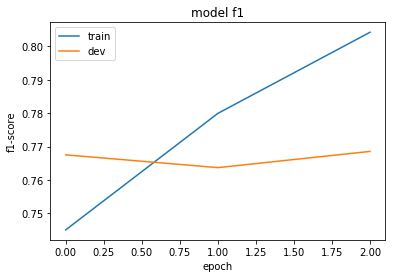

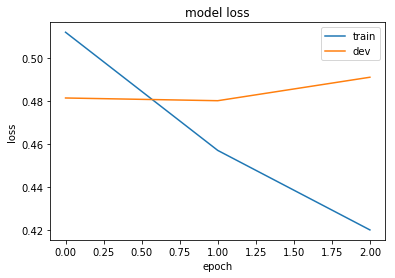

In [13]:
# summarize history for f1
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1-score')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

* From the above results it can be seen that our model learns the weights of the network very quickly, resulting to overfitting after the 2nd epoch.

## Evaluate performance of tf-idf MLP model

In [14]:
model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1] , activation='relu'))
model.add(Dense(64,  activation='relu'))
model.add(Dense(1,  activation='sigmoid'))
#load weights from the pre-trained model
model.load_weights("keras_tf_idf_model")
model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=[precision, recall, f1, accuracy])

score = model.evaluate(
    x_test,
    y_test,          
    batch_size=32,
    verbose=1)

print('\nTest Binary_cross_entropy: %.4f' %  (score[0]))
print('\nTest precision: %.4f' %  (score[1]))
print('\nTest recall: %.4f' %  (score[2]))
print('\nTest f1: %.4f' % (score[3]))
print('\nTest accuracy: %.4f'% (score[4]))

64000/64000 [==============================] - 5s 85us/step

Test Binary_cross_entropy: 0.4963

Test precision: 0.7512

Test recall: 0.7945

Test f1: 0.7667

Test accuracy: 0.7657


In [15]:
predictions = model.predict(x_test)
predictions = predictions.reshape(len(predictions),)

for i in range(len(predictions)):
    if predictions[i]<0.5:
        predictions[i]=0
    else:
        predictions[i]=1

y_true = pd.Series(y_test, name='True')
y_pred = pd.Series(predictions, name='Predicted')
pd.crosstab(y_true, y_pred)

Predicted,0.0,1.0
True,,
0,23503,8419
1,6578,25500


### Types of mistakes that MLP classifier makes.

In [16]:
for i in range(40):
    if y_true[i]!= y_pred[i]:
        print("Preprocessed Tweet:",X_test[i] )
        print("Predicted probability:",model.predict(x_test[i]))
        print("------------------------------------------------")

Preprocessed Tweet: listening to ciccilleju quot martina quot brings me so many memory 2004 nostalgia even candytron by kb kick in am that old already
Predicted probability: [[0.8506266]]
------------------------------------------------
Preprocessed Tweet: had late dinner too it 4 05am here now though and cant sleep gt lt whats the time where you are
Predicted probability: [[0.16207504]]
------------------------------------------------
Preprocessed Tweet: and will send the whole thing to you
Predicted probability: [[0.456932]]
------------------------------------------------
Preprocessed Tweet: i think understand why people don walk around la now it not because it spread out it cause it so ugly
Predicted probability: [[0.24862266]]
------------------------------------------------
Preprocessed Tweet: m ninja tized gangster be jealous
Predicted probability: [[0.390625]]
------------------------------------------------
Preprocessed Tweet: depends if you follow people to get them to follow

### Hyperparameter fine-tuning

* We fine-tune only a fews parameters of the MLP classifier due to lack of computational resources. Those parameters are:
    * layers = [2, 3]
    * nodes = [64, 128, 256]
    * dropout = 0.3
    * epochs = 4

In [12]:
nodes = [64, 128, 256]
dropout = 0.3
epochs = 4
history_list1 = []
history_list2 = []

for node1 in nodes:
    for node2 in nodes:
        if node1>=node2:
            model = Sequential()
            model.add(Dense(node1, input_dim=x_train.shape[1] , activation='relu'))
            model.add(Dropout(dropout))
            model.add(Dense(node2, activation='relu'))
            model.add(Dropout(dropout))
            model.add(Dense(1, activation='sigmoid'))
            print(model.summary())
            model.compile(loss='binary_crossentropy',
                          optimizer=Adam(lr=0.001),
                          metrics=[precision, recall, f1, accuracy])
            checkpoint = ModelCheckpoint('keras_tf_idf_model', monitor='val_f1', verbose=1, save_best_only=True, mode='max')
            earlystopping=EarlyStopping(monitor='val_f1', patience=2, verbose=1)
            history = model.fit(x_train, y_train,
                                batch_size=32,
                                epochs=epochs,
                                verbose = 0,
                                callbacks=[checkpoint,earlystopping,TQDMNotebookCallback()],
                                validation_data=(x_dev, y_dev),
                                shuffle=True)
            history_list1.append([node1, node2, history.history['val_f1']])

for node1 in nodes:
    for node2 in nodes:
        for node3 in nodes:
            if node1>=node2 and node2>=node3:
                model = Sequential()
                model.add(Dense(node1, input_dim=x_train.shape[1] , activation='relu'))
                model.add(Dropout(dropout))
                model.add(Dense(node2, activation='relu'))
                model.add(Dropout(dropout))
                model.add(Dense(node3, activation='relu'))
                model.add(Dropout(dropout))
                model.add(Dense(1, activation='sigmoid'))
                print(model.summary())
                model.compile(loss='binary_crossentropy',
                              optimizer=Adam(lr=0.001),
                              metrics=[precision, recall, f1, accuracy])
                checkpoint = ModelCheckpoint('keras_tf_idf_model', monitor='val_f1', verbose=1, save_best_only=True, mode='max')
                history = model.fit(x_train, y_train,
                                    batch_size=32,
                                    epochs=epochs,
                                    verbose = 0,
                                    callbacks=[checkpoint,TQDMNotebookCallback()],
                                    validation_data=(x_dev, y_dev),
                                    shuffle=True)
                history_list2.append([node1, node2, node3, history.history['val_f1']])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 64)                640064    
_________________________________________________________________
dropout_29 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_30 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 65        
Total params: 644,289
Trainable params: 644,289
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76364, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76364



Epoch 00003: val_f1 did not improve from 0.76364



Epoch 00004: val_f1 did not improve from 0.76364
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 128)               1280128   
_________________________________________________________________
dropout_31 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_32 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 65        
Total params: 1,288,449
Trainable params: 1,288,449
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76685, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76685 to 0.77014, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.77014



Epoch 00004: val_f1 did not improve from 0.77014
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 128)               1280128   
_________________________________________________________________
dropout_33 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_34 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 129       
Total params: 1,296,769
Trainable params: 1,296,769
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76418, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76418



Epoch 00003: val_f1 did not improve from 0.76418



Epoch 00004: val_f1 did not improve from 0.76418
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 256)               2560256   
_________________________________________________________________
dropout_35 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_36 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 65        
Total params: 2,576,769
Trainable params: 2,576,769
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.75871, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75871 to 0.76288, saving model to keras_tf_idf_model



Epoch 00003: val_f1 improved from 0.76288 to 0.76501, saving model to keras_tf_idf_model
Epoch 00003: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 256)               2560256   
_________________________________________________________________
dropout_37 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_38 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 129       
Total params: 2,593,281
Trainable params: 2,593,281
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.75254, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75254 to 0.76309, saving model to keras_tf_idf_model



Epoch 00003: val_f1 improved from 0.76309 to 0.76580, saving model to keras_tf_idf_model
Epoch 00003: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 256)               2560256   
_________________________________________________________________
dropout_39 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_40 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 257       
Total params: 2,626,305
Trainable params: 2,626,305
Non-trainable params: 0
_________________________________________________________________
None



Epoch 00001: val_f1 improved from -inf to 0.76107, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76107 to 0.76764, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76764



Epoch 00004: val_f1 did not improve from 0.76764
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 64)                640064    
_________________________________________________________________
dropout_41 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_42 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_61 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_43 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_62 (Dense)          


Epoch 00001: val_f1 improved from -inf to 0.76729, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76729



Epoch 00003: val_f1 did not improve from 0.76729



Epoch 00004: val_f1 did not improve from 0.76729
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 128)               1280128   
_________________________________________________________________
dropout_44 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_45 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_65 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_46 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_66 (Dense)          


Epoch 00001: val_f1 improved from -inf to 0.76634, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76634



Epoch 00003: val_f1 did not improve from 0.76634



Epoch 00004: val_f1 did not improve from 0.76634
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 128)               1280128   
_________________________________________________________________
dropout_47 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_68 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_48 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_49 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_70 (Dense)          


Epoch 00001: val_f1 improved from -inf to 0.76361, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76361 to 0.76800, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76800



Epoch 00004: val_f1 did not improve from 0.76800
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 128)               1280128   
_________________________________________________________________
dropout_50 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_51 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_52 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_74 (Dense)          


Epoch 00001: val_f1 improved from -inf to 0.76654, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76654



Epoch 00003: val_f1 did not improve from 0.76654



Epoch 00004: val_f1 did not improve from 0.76654
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 256)               2560256   
_________________________________________________________________
dropout_53 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_54 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_77 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_55 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_78 (Dense)          


Epoch 00001: val_f1 improved from -inf to 0.75605, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75605 to 0.75611, saving model to keras_tf_idf_model



Epoch 00003: val_f1 improved from 0.75611 to 0.76325, saving model to keras_tf_idf_model
Epoch 00003: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 256)               2560256   
_________________________________________________________________
dropout_56 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_80 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_57 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_58 (Dropout)         (None, 64)                0         
________________________


Epoch 00001: val_f1 improved from -inf to 0.76491, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76491



Epoch 00003: val_f1 did not improve from 0.76491



Epoch 00004: val_f1 did not improve from 0.76491
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_83 (Dense)             (None, 256)               2560256   
_________________________________________________________________
dropout_59 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_84 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_60 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_85 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_61 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_86 (Dense)          


Epoch 00001: val_f1 improved from -inf to 0.75545, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.75545 to 0.75680, saving model to keras_tf_idf_model



Epoch 00003: val_f1 improved from 0.75680 to 0.75818, saving model to keras_tf_idf_model
Epoch 00003: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_87 (Dense)             (None, 256)               2560256   
_________________________________________________________________
dropout_62 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_88 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_63 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_89 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_64 (Dropout)         (None, 64)                0         
________________________


Epoch 00001: val_f1 improved from -inf to 0.76850, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.76850



Epoch 00003: val_f1 did not improve from 0.76850



Epoch 00004: val_f1 did not improve from 0.76850
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_91 (Dense)             (None, 256)               2560256   
_________________________________________________________________
dropout_65 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_92 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_66 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_93 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_67 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_94 (Dense)          


Epoch 00001: val_f1 improved from -inf to 0.76126, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76126 to 0.76872, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.76872



Epoch 00004: val_f1 did not improve from 0.76872
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_95 (Dense)             (None, 256)               2560256   
_________________________________________________________________
dropout_68 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_96 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_69 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_97 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_70 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_98 (Dense)          


Epoch 00001: val_f1 improved from -inf to 0.76179, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.76179 to 0.77300, saving model to keras_tf_idf_model



Epoch 00003: val_f1 did not improve from 0.77300



Epoch 00004: val_f1 did not improve from 0.77300


### Visualize Tuning Results

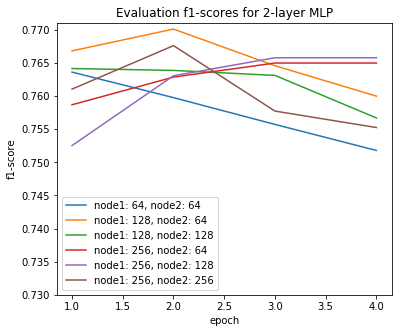

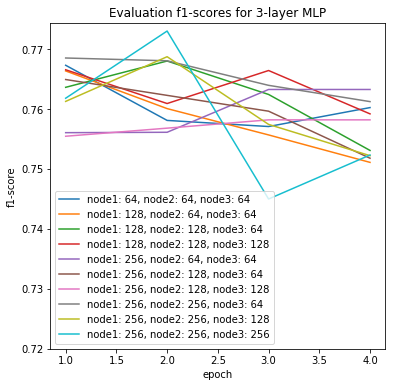

In [64]:
legends = []
plt.figure(figsize=(6,5))
for i in range(len(history_list1)):
    plt.plot(np.arange(1,epochs+1), history_list1[i][2])
    legends.append('node1: ' + str(history_list1[i][0]) + ', node2: ' + str(history_list1[i][1]))
plt.title('Evaluation f1-scores for 2-layer MLP')
plt.ylabel('f1-score')
plt.xlabel('epoch')
plt.ylim(bottom=0.73)
plt.legend(legends)
plt.show()

legends = []
plt.figure(figsize=(6,6))
for i in range(len(history_list2)):
    plt.plot(np.arange(1,epochs+1), history_list2[i][3])
    legends.append('node1: ' + str(history_list2[i][0]) + ', node2: ' + str(history_list2[i][1]) + 
                   ', node3: ' + str(history_list2[i][2]))
plt.title('Evaluation f1-scores for 3-layer MLP')
plt.ylabel('f1-score')
plt.xlabel('epoch')
plt.ylim(bottom=0.72)
plt.legend(legends)
plt.show()

* We see that the best results (F1-Score:77.30%) are obtained for a 3-layer percepton with 256 nodes per layer and dropout=0.3 trained for 2 epochs.

## Compare MLP Models's results with the must simpler and quicker SGDClassifier



In [25]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score

clf = SGDClassifier(loss="log", penalty="l2", tol=0.0001)
clf.fit(x_train, y_train)
predictions = clf.predict(x_train)
score = f1_score(y_train,predictions)
print("SGD Classifier")
print('---------------')
print("Train f1-score: %.2f%%"%(score*100))

predictions = clf.predict(x_dev)
score = f1_score(y_dev, predictions)
print("Development f1-score: %.2f%%"%(score*100))
print()
print("Developmen data confusion matrix")
y_true = pd.Series(y_dev, name='True')
y_pred = pd.Series(predictions, name='Predicted')
pd.crosstab(y_true, y_pred)


SGD Classifier
---------------
Train f1-score: 76.96%
Development f1-score: 76.25%

Developmen data confusion matrix


Predicted,0,1
True,,
0,11724,4367
1,3416,12493


* It can be seen that the NN performs shlitly better (1.13%) than the SGD Classifier. This means that may be better to use a simpler model for this classification task.  